# Networks of organisations


  
* *Exploratory SNA* book's chapter 5 about 'Affiliations'
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/pajek_book/chapter5_affiliations.ipynb) 



In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet

%matplotlib inline

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import scipy.stats as stats

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [5]:
print(reload(naf))  

<module 'network_analysis_functions' from 'c:\\Users\\rroll\\Documents\\GitHub\\2HS2179_militants-pour-la-paix\\notebooksJupyter\\network_analysis_functions.py'>


## Get the data from the triplestore

This notebook is based on the same relationships (and therefore data) as [the one about persons' relationships](wdt_persons_organisations_networks.ipynb), namely the relationship between persons and organisations as original information.

Here, however, we will focus on relationships between institutions, so the treatment is different.


In [4]:
## define SPARQL enpoint
endpoint = "https://ag132kz7jrzck2hf.allegrograph.cloud/repositories/peace/sparql"

In [5]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/Raphix93/2HS2179_militants-pour-la-paix/blob/main/wikidata/graph/imported-data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                # instance of
                wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [6]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


679
[['http://www.wikidata.org/entity/Q133281500',
  'Christina Gibb',
  '1929',
  'employment',
  'http://www.wikidata.org/entity/Q17509124',
  'Chilton Saint James School',
  '3',
  'combined school | private school | secondary school'],
 ['http://www.wikidata.org/entity/Q133281500',
  'Christina Gibb',
  '1929',
  'employment',
  'http://www.wikidata.org/entity/Q1150437',
  'Victoria University of Wellington',
  '1',
  'public university'],
 ['http://www.wikidata.org/entity/Q133734026',
  'Henning Zierock',
  '1951',
  'membership',
  'http://www.wikidata.org/entity/Q133734335',
  'Society Culture of Peace',
  '1',
  'peace organization']]


## Inspect the data


In [7]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesOrg']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  679


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg
10,http://www.wikidata.org/entity/Q105593,Friedrich Siegmund-Schultze,1885,employment,http://www.wikidata.org/entity/Q20266330,Frederick William University Berlin,1,university
11,http://www.wikidata.org/entity/Q105840219,Gwyn Kirk,1945,membership,http://www.wikidata.org/entity/Q5604092,Greenham Common Women's Peace Camp,1,peace camp
12,http://www.wikidata.org/entity/Q105876,Horst-Eberhard Richter,1923,employment,http://www.wikidata.org/entity/Q165980,University of Vienna,1,university


### Distribution of relationships in relation to birthYears of organisations members

In [9]:
l_50 = list(range(1800, 2000, 50))
print(l_50)

[1800, 1850, 1900, 1950]


In [10]:
### We adapt the periods manually,
# we would like to have eight periods
# making sense from an historical point of view 
lc = [1800, 1830, 1860, 1890, 1920, 1950, 1980, 2010]

In [11]:
### 30 years periods, but some customisations
lc = [1751, 1811, 1851, 1881, 1911, 1941, 1971, 2001]

In [12]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [13]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods
1,http://www.wikidata.org/entity/Q1001,Mahatma Gandhi,1869,membership,http://www.wikidata.org/entity/Q2154954,Vegetarian Society,2,charitable organization | club,1851-1880
5,http://www.wikidata.org/entity/Q105301557,Sofia Spångberg,1898,membership,http://www.wikidata.org/entity/Q105317493,Q105317493,1,voluntary association,1881-1910
10,http://www.wikidata.org/entity/Q105593,Friedrich Siegmund-Schultze,1885,employment,http://www.wikidata.org/entity/Q20266330,Frederick William University Berlin,1,university,1881-1910


In [14]:
df_p.to_csv('data/persons_organisations_from_organisations.csv', index=False, encoding='utf-8')


#### Reload from CSV

This is only possible if you already stored the data into a CSV, cf. below

In [14]:
### load from CSV

file_add = 'data/persons_organisations_from_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

679


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q1001,Mahatma Gandhi,1869,membership,http://www.wikidata.org/entity/Q1233784,Inner Temple,3,educational institution | inns of court | univ...,1860-1889,"['educational institution', 'inns of court', '..."
1,http://www.wikidata.org/entity/Q1001,Mahatma Gandhi,1869,membership,http://www.wikidata.org/entity/Q2154954,Vegetarian Society,2,charitable organization | club,1860-1889,"['charitable organization', 'club']"


In [15]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1800-1829     11
1830-1859     16
1860-1889    156
1890-1919    156
1920-1949    246
1950-1979     92
1980-2009      2
dtype: int64


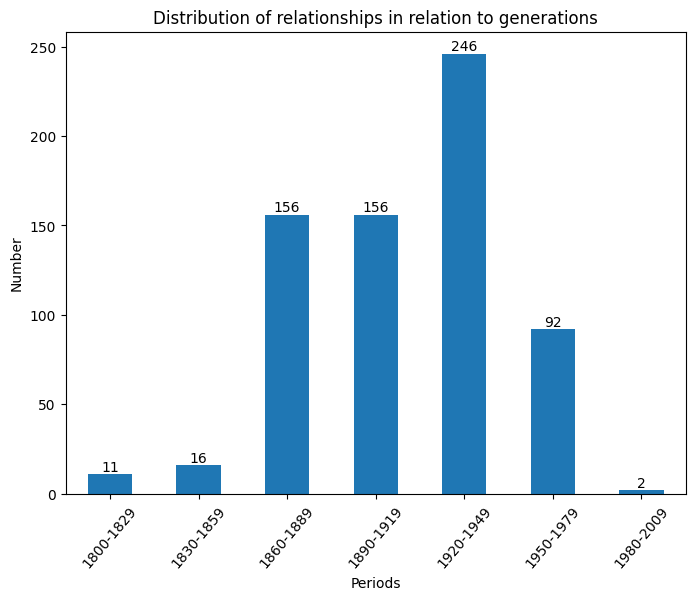

In [16]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Inspect available relationships

In [17]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
employment    357
membership    322
dtype: int64


In [18]:
dfg_pr=df_p.groupby(by=['periods','relaType'], observed=True, as_index=False).size()
print(dfg_pr)

      periods    relaType  size
0   1800-1829  membership    11
1   1830-1859  employment     5
2   1830-1859  membership    11
3   1860-1889  employment    53
4   1860-1889  membership   103
5   1890-1919  employment    79
6   1890-1919  membership    77
7   1920-1949  employment   162
8   1920-1949  membership    84
9   1950-1979  employment    57
10  1950-1979  membership    35
11  1980-2009  employment     1
12  1980-2009  membership     1


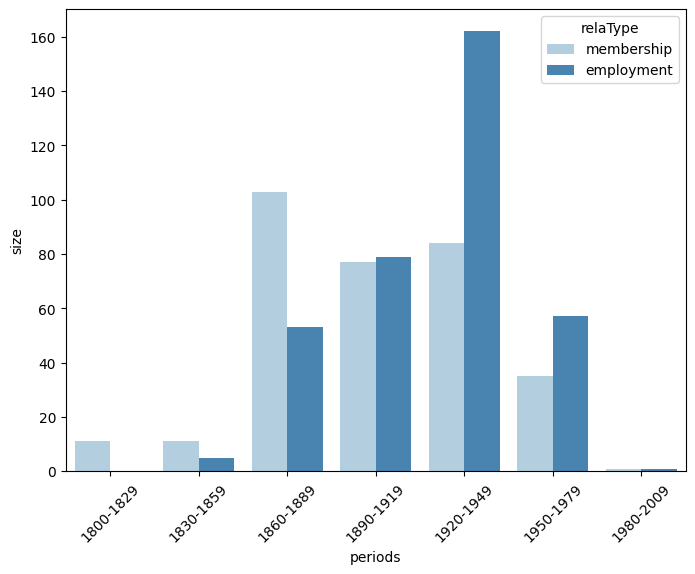

In [19]:
%matplotlib inline
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(data=dfg_pr, x='periods', y='size', hue='relaType', palette='Blues')
ax.tick_params(axis='x', labelrotation=45)


### Clean up organisations type

In [20]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['listTypesOrg'] = df_p.typesOrg.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

ll = df_p.listTypesOrg.to_list()
print(len(ll))
pprint.pprint(ll[:3])


679
[['educational institution', 'inns of court', 'university building'],
 ['charitable organization', 'club'],
 ['public educational institution of the united states', 'university campus']]


In [21]:
## Rebuild the sorted original texts after sorting
df_p['typesOrg'] = df_p.listTypesOrg.apply(lambda x : ' | '.join(x))
df_p.iloc[[1,5,10]]


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
1,http://www.wikidata.org/entity/Q1001,Mahatma Gandhi,1869,membership,http://www.wikidata.org/entity/Q2154954,Vegetarian Society,2,charitable organization | club,1860-1889,"[charitable organization, club]"
5,http://www.wikidata.org/entity/Q105301557,Sofia Spångberg,1898,membership,http://www.wikidata.org/entity/Q105317493,Q105317493,1,voluntary association,1890-1919,[voluntary association]
10,http://www.wikidata.org/entity/Q105593,Friedrich Siegmund-Schultze,1885,employment,http://www.wikidata.org/entity/Q20266330,Frederick William University Berlin,1,university,1860-1889,[university]


#### Organisations' types distribution

In [22]:
print(df_p.groupby('typesOrg').size().sort_values(ascending=False).iloc[:10])

typesOrg
organization                                                                                                     44
international organization | non-governmental organization | nonprofit organization | women's organization       26
international organization | peace organization | women's organization                                           22
university                                                                                                       17
academic publisher | learned society | nonprofit organization                                                    15
colonial colleges | private not-for-profit educational institution | private university | research university    13
intergovernmental organization | international organization                                                      10
musical group                                                                                                    10
political organization                                         

#### Save dataframe to CSV

In [23]:
file_add = 'data/persons_organisations_from_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

## Types of organisations

Property **wdt:P31 instance of**


We are trying to figure out if we can use these types to distinguish and categorise organisations. We will introduce high-level, research-driven classes that primarily serve a heuristic function and express no objective point of view.

In [24]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby('typesOrg').size().sort_values(ascending=False))
df_types.reset_index(inplace=True)
df_types.columns=['typesOrg', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
df_types.iloc[:10]

,typesOrg,number,numberOrg
0,organization,44,1
1,international organization | non-governmental ...,26,4
2,international organization | peace organizatio...,22,3
3,university,17,1
4,academic publisher | learned society | nonprof...,15,3
5,colonial colleges | private not-for-profit edu...,13,4
6,intergovernmental organization | international...,10,2
7,musical group,10,1
8,political organization,9,1
9,private not-for-profit educational institution...,8,2


In [25]:
### Print to CSV in order to inspect the data
csv_file='data/network_organisations_types_groups.csv'
df_types.to_csv(csv_file)

### Add organisation main type

In [26]:
### Inspect the data
df_p.head(1)

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q1001,Mahatma Gandhi,1869,membership,http://www.wikidata.org/entity/Q1233784,Inner Temple,3,educational institution | inns of court | univ...,1860-1889,"[educational institution, inns of court, unive..."


In [27]:
def code_organisation_main_type(x):
    x = x.lower()
    
    if 'colonial colleges' in x \
        or 'private not-for-profit educational institution' in x \
        or 'private university' in x \
        or 'university' in x \
        or 'research university' in x:
        return 'university'
    
    elif 'academic publisher' in x \
        or 'learned society' in x:
        return 'learned society'
    
    elif 'international organization' in x \
        or 'intergovernmental organization' in x:
        return 'international organisation'
    
    elif 'non-governmental organization' in x \
        or 'peace organization' in x \
        or "women's organization" in x:
        return 'non-governmental organisation'
    
    elif 'political organization' in x:
        return 'political organisation'
    
    elif 'musical group' in x:
        return 'musical group'
    
    else:
        return 'generic organisation'
 

In [28]:
df_p['orgMainType'] = df_p['typesOrg'].apply(lambda x : code_organisation_main_type(x))
df_p.iloc[7:10]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
7,http://www.wikidata.org/entity/Q105583600,Ken Weller,1936,membership,http://www.wikidata.org/entity/Q7577135,Spies for Peace,1,group of humans,1920-1949,[group of humans],generic organisation
8,http://www.wikidata.org/entity/Q105593,Friedrich Siegmund-Schultze,1885,employment,http://www.wikidata.org/entity/Q152087,Humboldt-Universität zu Berlin,4,comprehensive university | open-access publish...,1860-1889,"[comprehensive university, open-access publish...",university
9,http://www.wikidata.org/entity/Q105593,Friedrich Siegmund-Schultze,1885,employment,http://www.wikidata.org/entity/Q168426,University of Münster,3,comprehensive university | local internet regi...,1860-1889,"[comprehensive university, local internet regi...",university


In [29]:
df_mainTypes = pd.DataFrame(df_p.groupby(by='orgMainType', as_index=False).size().sort_values(by='size',ascending=False))
df_mainTypes.columns=['mainType', 'number']
df_mainTypes

,mainType,number
0,generic organisation,275
6,university,229
1,international organisation,72
4,non-governmental organisation,40
2,learned society,36
5,political organisation,14
3,musical group,13


In [30]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby(['typesOrg', 'orgMainType'], as_index=False).\
                        size().sort_values(by='size',ascending=False))
df_types.columns=['typesOrg', 'orgMainType', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
### Print to CSV in order to inspect the data
csv_file='data/network_organisations_with_main_types_groups.csv'
df_types.to_csv(csv_file)

df_types.iloc[7:10]

,typesOrg,orgMainType,number,numberOrg
200,musical group,musical group,10,1
268,political organization,political organisation,9,1
277,private not-for-profit educational institution...,university,8,2


# Create graphs

In [31]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
employment    357
membership    322
dtype: int64


### Prepare the dataframe

In [32]:
### Select the columns that will be used
df_prep = df_p[['uriPer','labelPer','birthYear','uriOrg', 'labelOrg', 'typesOrg', 'orgMainType', 'relaType', 'periods']].copy(deep=True)
print(len(df_prep))

679


### Features of organisations

#### General grouping


We first group by organisations, counting all relationships of persons which provides the total degree or number of members over the whole time 

In [33]:
### Memberships by organisations
df_org = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'typesOrg','orgMainType'],as_index=False).size())
df_org.columns=['uriOrg', 'labelOrg', 'typesOrg', 'orgMainType','tot_members_number']
df_org.sort_values('tot_members_number',ascending=False).iloc[:10]

,uriOrg,labelOrg,typesOrg,orgMainType,tot_members_number
395,http://www.wikidata.org/entity/Q689768,Women's International League for Peace and Fre...,international organization | non-governmental ...,international organisation,26
371,http://www.wikidata.org/entity/Q60564688,International Committee of Women for Permanent...,international organization | peace organizatio...,international organisation,19
293,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,academic publisher | learned society | nonprof...,learned society,15
82,http://www.wikidata.org/entity/Q13371,Harvard University,colonial colleges | private not-for-profit edu...,university,13
317,http://www.wikidata.org/entity/Q49088,Columbia University,colonial colleges | organization | private not...,university,8
378,http://www.wikidata.org/entity/Q623009,National Woman's Party,organization | political party,generic organisation,7
15,http://www.wikidata.org/entity/Q1065,United Nations,intergovernmental organization | international...,international organisation,7
400,http://www.wikidata.org/entity/Q7045639,Nobel Women's Initiative,advocacy group | international organization,international organisation,6
292,http://www.wikidata.org/entity/Q463281,American Academy of Arts and Letters,academy of sciences | award,generic organisation,6
279,http://www.wikidata.org/entity/Q41506,Stanford University,open-access publisher | private not-for-profit...,university,6


In [34]:
### Save list of organisations as CSV
csv_file='data/network_organisations_with_main_type_and_number.csv'
df_org.sort_values('tot_members_number',ascending=False).to_csv(csv_file)

#### Group by period

We then group by heuristic period (or generation)

In [35]:
df_orgPeriod = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriod.reset_index(inplace=True)
df_orgPeriod.sort_values(by='periods', ascending=True).head()

,uriOrg,labelOrg,orgMainType,periods,period_members_number
404,http://www.wikidata.org/entity/Q529564,Association of German Engineers,generic organisation,1800-1829,1
492,http://www.wikidata.org/entity/Q76391871,Société pour l'amélioration du sort de la femm...,generic organisation,1800-1829,1
362,http://www.wikidata.org/entity/Q4903078,Bible Christian Church,generic organisation,1800-1829,1
183,http://www.wikidata.org/entity/Q188771,French Academy of Sciences,generic organisation,1800-1829,1
248,http://www.wikidata.org/entity/Q2583804,American Anti-Imperialist League,political organisation,1800-1829,1


#### Group by period and relationship type

We then group by heuristic period (or generation) AND relationship type, i.e. which kind of relationship associates a person to an organisation in the bipartite network

In [36]:
df_orgPeriodRelType = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriodRelType.reset_index(inplace=True)
df_orgPeriodRelType.sort_values(by='period_members_number', ascending=False).head()

,uriOrg,labelOrg,orgMainType,relaType,periods,period_members_number
430,http://www.wikidata.org/entity/Q60564688,International Committee of Women for Permanent...,international organisation,membership,1860-1889,17
461,http://www.wikidata.org/entity/Q689768,Women's International League for Peace and Fre...,international organisation,membership,1860-1889,16
340,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,membership,1920-1949,10
462,http://www.wikidata.org/entity/Q689768,Women's International League for Peace and Fre...,international organisation,membership,1890-1919,6
93,http://www.wikidata.org/entity/Q13371,Harvard University,university,employment,1920-1949,6


In [37]:
### Number of relationships by period with type
dfgt = df_orgPeriodRelType.groupby(['periods', 'relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values(['relaType', 'periods'])
file_addr='data/organisations_types_periods_distribution.csv'
dfgt.sort_values(['relaType', 'periods']).to_csv(file_addr)
print(len(dfgt))
dfgt.iloc[:10]

50


,periods,relaType,orgMainType,period_members_number
3,1830-1859,employment,generic organisation,2
4,1830-1859,employment,university,3
8,1860-1889,employment,generic organisation,16
9,1860-1889,employment,international organisation,3
10,1860-1889,employment,non-governmental organisation,4
11,1860-1889,employment,university,30
18,1890-1919,employment,generic organisation,25
19,1890-1919,employment,international organisation,3
20,1890-1919,employment,non-governmental organisation,3
21,1890-1919,employment,university,48


In [38]:
### Number of relationships without period
dfgw = df_orgPeriodRelType.groupby(['relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values([ 'relaType', 'orgMainType'])
print(len(dfgw))

12


## Bivariate analysis: relationship, organisation type

### Create the needed functions

In [39]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [40]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

    return residus_ponderes

### Explore contingency table : types of relationships, types of organisations

In [41]:


### Contingency table
X = 'relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



relaType,employment,membership,Total
orgMainType,,,
generic organisation,102,173,275
international organisation,11,61,72
learned society,0,36,36
musical group,0,13,13
non-governmental organisation,15,25,40
political organisation,1,13,14
university,228,1,229
Total,357,322,679


In [42]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)
ct_wm

relaType,employment,membership
orgMainType,,
generic organisation,102,173
international organisation,11,61
learned society,0,36
musical group,0,13
non-governmental organisation,15,25
political organisation,1,13
university,228,1


In [43]:
### We observe a strong relationship between these two variables

bivariee_stats(ct_wm)

Chi2 : 338.95 , dof : 6
p-value : 3.627845453123343e-70
phi2 = inertie (variance totale) : 0.4991941046497402
Cramer:  0.7065366973128432


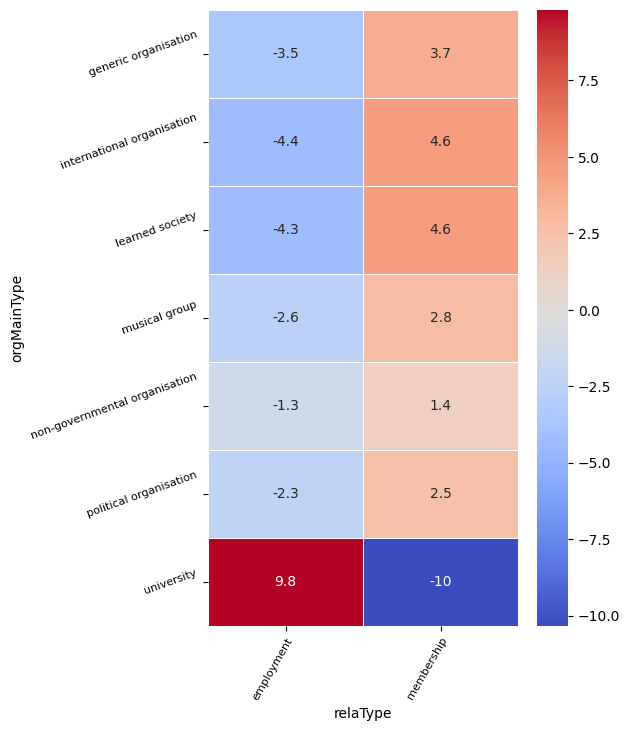

In [44]:
pp = plot_chi2_residuals(ct_wm, figsize=(5, 8))

#### Comment

We observe a strong relationship between these two variables which is explained by the fact that not all organisations types are concerned by the same relationship types

We also observe that some values should be corrected, like memberships in technical organisations that should be employments.

See the following example

In [45]:
pprint.pprint(list(df_p.loc[df_p.orgMainType.str.contains('techno') & df_p.relaType.str.contains('memb') ].items())[:6])

[('uriPer', Series([], Name: uriPer, dtype: object)),
 ('labelPer', Series([], Name: labelPer, dtype: object)),
 ('birthYear', Series([], Name: birthYear, dtype: int64)),
 ('relaType', Series([], Name: relaType, dtype: object)),
 ('uriOrg', Series([], Name: uriOrg, dtype: object)),
 ('labelOrg', Series([], Name: labelOrg, dtype: object))]


### Explore contingency table of relationships to organisations : periods, types of organisations

In [46]:
### Contingency table
X = 'periods'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1800-1829,1830-1859,1860-1889,1890-1919,1920-1949,1950-1979,1980-2009,Total
orgMainType,,,,,,,,
generic organisation,9,8,67,68,85,36,2,275
international organisation,0,4,38,15,9,6,0,72
learned society,1,0,6,13,16,0,0,36
musical group,0,0,0,1,6,6,0,13
non-governmental organisation,0,0,11,10,10,9,0,40
political organisation,1,1,3,1,3,5,0,14
university,0,3,31,48,117,30,0,229
Total,11,16,156,156,246,92,2,679


In [47]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [48]:
### We observe some not so strong relationship between these two variables
bivariee_stats(ct_wm)

Chi2 : 126.32 , dof : 36
p-value : 5.746898400864133e-12
phi2 = inertie (variance totale) : 0.18603723053874469
Cramer:  0.1760857890057877


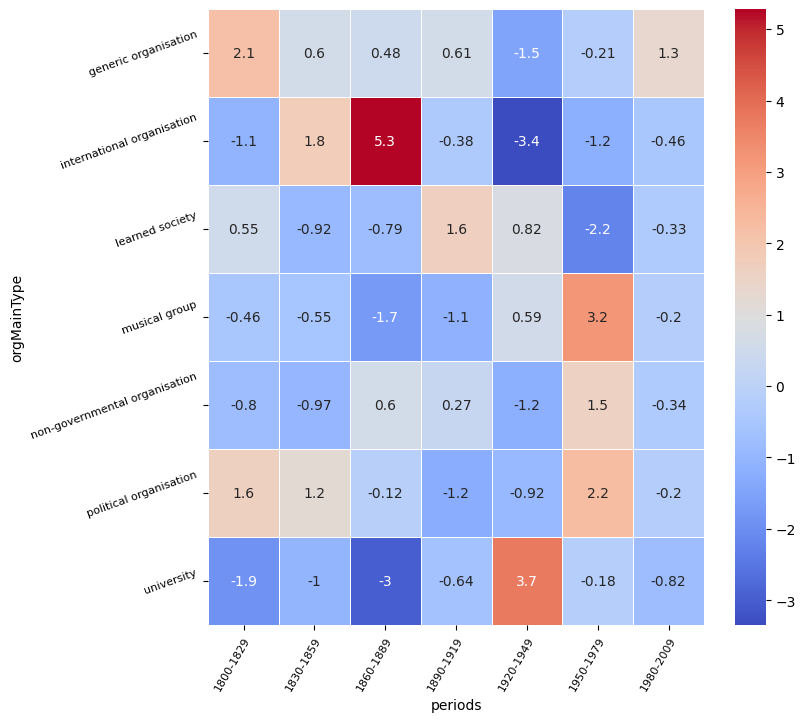

In [49]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 8))

### Explore contingency table of relationships to organisations : periods, types of relationships

In [50]:
### Contingency table
X = 'periods'
Y = 'relaType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1800-1829,1830-1859,1860-1889,1890-1919,1920-1949,1950-1979,1980-2009,Total
relaType,,,,,,,,
employment,0,5,53,79,162,57,1,357
membership,11,11,103,77,84,35,1,322
Total,11,16,156,156,246,92,2,679


In [51]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [52]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 57.64 , dof : 6
p-value : 1.3536926696125126e-10
phi2 = inertie (variance totale) : 0.08489380581775278
Cramer:  0.2913654163035702


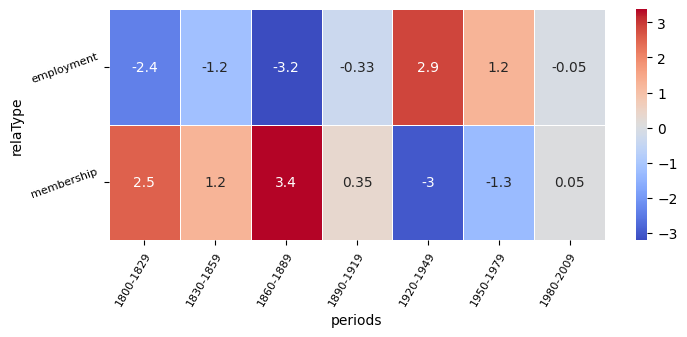

In [53]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 3))

### Explore contingency table of relationships to organisations : periods+types of relationships vs organisations types

In [54]:
df_prep['periods_relaType'] = df_prep.apply(lambda x : x.periods+'_'+x.relaType, axis=1)
df_prep.head(1)

,uriPer,labelPer,birthYear,uriOrg,labelOrg,typesOrg,orgMainType,relaType,periods,periods_relaType
0,http://www.wikidata.org/entity/Q1001,Mahatma Gandhi,1869,http://www.wikidata.org/entity/Q1233784,Inner Temple,educational institution | inns of court | univ...,university,membership,1860-1889,1860-1889_membership


In [55]:
### Contingency table
X = 'periods_relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods_relaType,1800-1829_membership,1830-1859_employment,1830-1859_membership,1860-1889_employment,1860-1889_membership,1890-1919_employment,1890-1919_membership,1920-1949_employment,1920-1949_membership,1950-1979_employment,1950-1979_membership,1980-2009_employment,1980-2009_membership,Total
orgMainType,,,,,,,,,,,,,,
generic organisation,9,2,6,16,51,25,43,39,46,19,17,1,1,275
international organisation,0,0,4,3,35,3,12,4,5,1,5,0,0,72
learned society,1,0,0,0,6,0,13,0,16,0,0,0,0,36
musical group,0,0,0,0,0,0,1,0,6,0,6,0,0,13
non-governmental organisation,0,0,0,4,7,3,7,2,8,6,3,0,0,40
political organisation,1,0,1,0,3,0,1,0,3,1,4,0,0,14
university,0,3,0,30,1,48,0,117,0,30,0,0,0,229
Total,11,5,11,53,103,79,77,162,84,57,35,1,1,679


In [56]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [57]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 505.32 , dof : 72
p-value : 2.575940405244834e-66
phi2 = inertie (variance totale) : 0.7442058258098526
Cramer:  0.3521850427000586


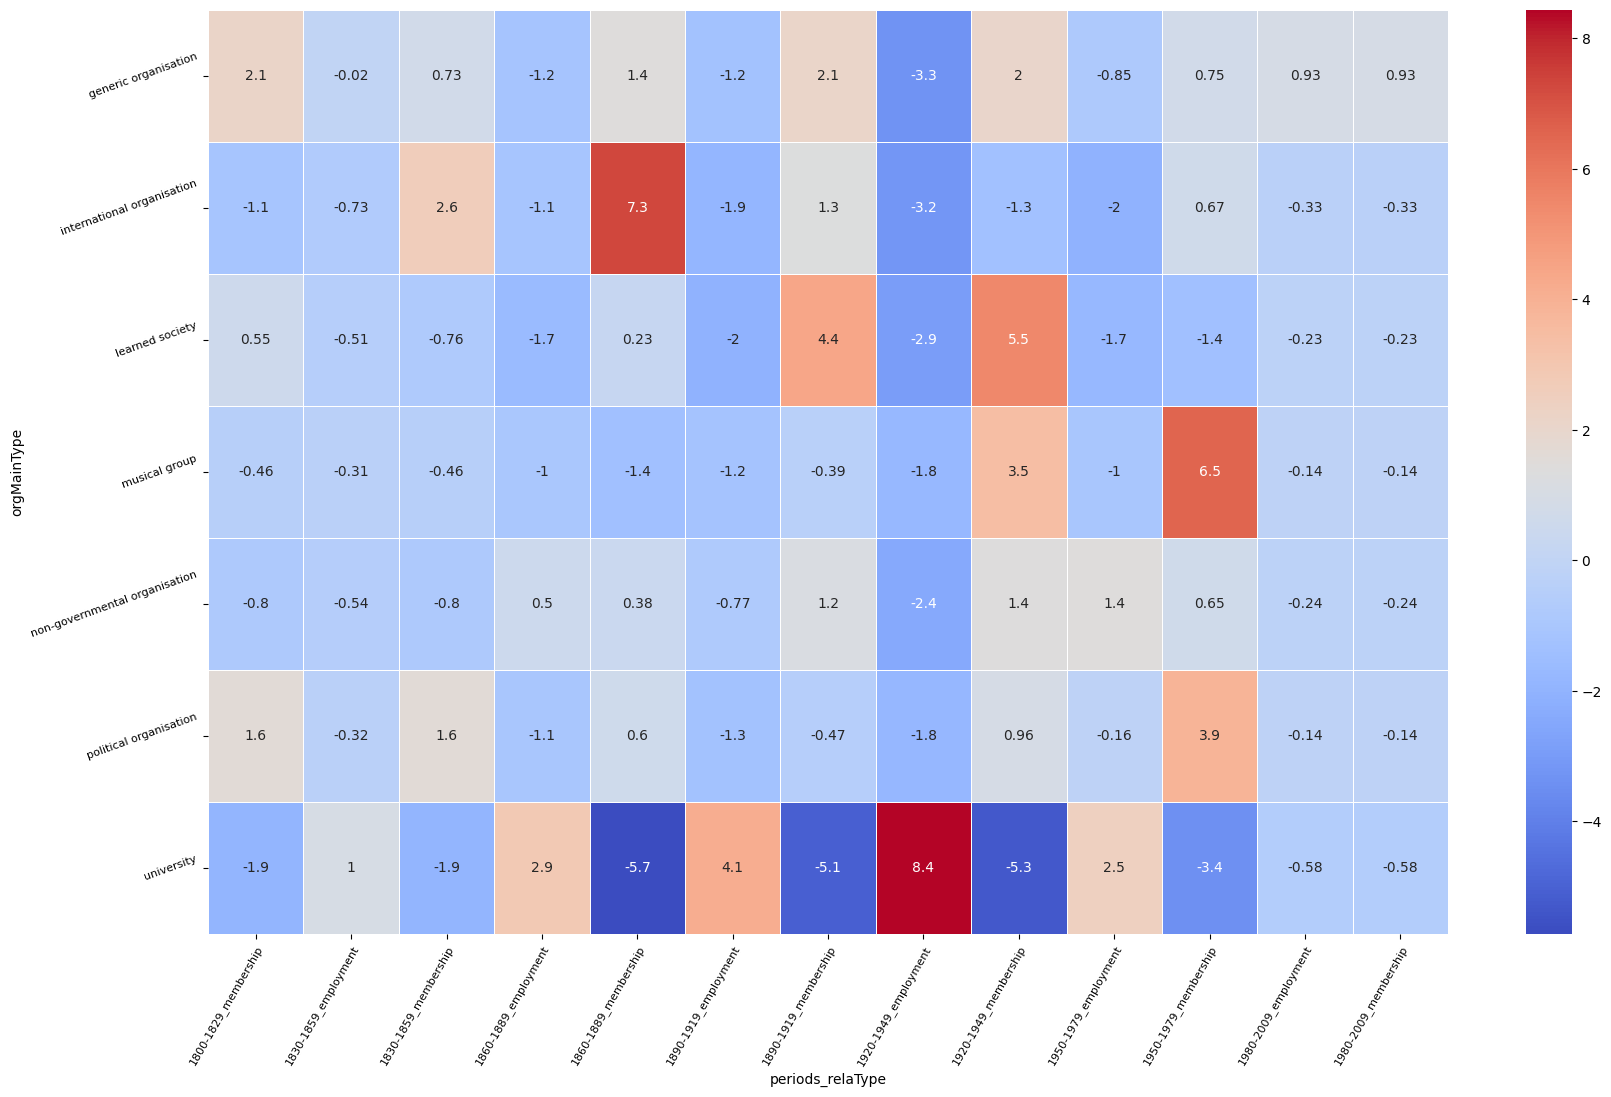

In [58]:
pp = plot_chi2_residuals(ct_wm, figsize=(20, 12))

## Prepare graph


In a heuristic perspective we take the persons as representing relationships among organisations.

Of course these relations are limited in time and with different meaning but in this general inspection of the field, we consider all the relationship. Filters are introduced later on.

We will create a projection of the graph on organisations and keep in a first stage all relationships, with types and periods, one per relationship, where the joining elements are those concerning uniquely the person

In [59]:
### Join on common organisation: Cartesian product -> produces a lot of rows !
merged = pd.merge(df_prep, df_prep, on=['uriPer','labelPer','birthYear', 'periods'])
print(len(merged))


2281


In [60]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriOrg_x'] < (merged['uriOrg_y'])]


In [61]:
### Inspect
print(len(merged))
print(list(merged.columns))
merged.iloc[110:114]

800
['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'periods_relaType_x', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'periods_relaType_y']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y
342,http://www.wikidata.org/entity/Q150281,Dorothy Day,1897,http://www.wikidata.org/entity/Q1544011,Pathé,cinema chain | film production company | film ...,generic organisation,employment,1890-1919,1890-1919_employment,http://www.wikidata.org/entity/Q511735,Commonweal,magazine,generic organisation,employment,1890-1919_employment
345,http://www.wikidata.org/entity/Q150281,Dorothy Day,1897,http://www.wikidata.org/entity/Q1544011,Pathé,cinema chain | film production company | film ...,generic organisation,employment,1890-1919,1890-1919_employment,http://www.wikidata.org/entity/Q7747057,The Liberator,magazine,generic organisation,employment,1890-1919_employment
346,http://www.wikidata.org/entity/Q150281,Dorothy Day,1897,http://www.wikidata.org/entity/Q1544011,Pathé,cinema chain | film production company | film ...,generic organisation,employment,1890-1919,1890-1919_employment,http://www.wikidata.org/entity/Q2157083,Silent Sentinels,group of humans | protest,generic organisation,membership,1890-1919_membership
347,http://www.wikidata.org/entity/Q150281,Dorothy Day,1897,http://www.wikidata.org/entity/Q1544011,Pathé,cinema chain | film production company | film ...,generic organisation,employment,1890-1919,1890-1919_employment,http://www.wikidata.org/entity/Q623009,National Woman's Party,organization | political party,generic organisation,membership,1890-1919_membership


In [62]:
### Available ORIGINAL relationships
print(df_p.groupby(by='relaType').size())

relaType
employment    357
membership    322
dtype: int64


In [63]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
0,employment,employment,265
3,membership,membership,257
2,membership,employment,146
1,employment,membership,132


### Swap values in order to have the same orientation for all relationships

All relationships should have the same 'orientation', which is determined by alphabetical order:

education -> employment -> membership

In [64]:
### Example
df = pd.DataFrame({
    'column1': ['A', 'B', 'C', 'D'],
    'column2': ['X', 'Y', 'Z', 'W']
})

condition = df['column1'] < df['column2']
df.loc[condition, ['column1', 'column2']] = df.loc[condition, ['column2', 'column1']].values

print(df)

  column1 column2
0       X       A
1       Y       B
2       Z       C
3       W       D


In [65]:
### Test whether the relationship types are in the wrong alphabetical order.
condition = merged.relaType_x > merged.relaType_y

In [66]:
### Transpose under condition that the relation orientation is 'wrong',
# i.e. not according the alphabatical order

merged.loc[condition, 
    ['uriOrg_x','labelOrg_x','orgMainType_x','relaType_x', 'uriOrg_y','labelOrg_y','orgMainType_y','relaType_y']] = \
        merged.loc[condition,
    ['uriOrg_y','labelOrg_y','orgMainType_y','relaType_y','uriOrg_x','labelOrg_x','orgMainType_x','relaType_x']].values

In [67]:
### Inspect

merged.iloc[110:117]

,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y
342,http://www.wikidata.org/entity/Q150281,Dorothy Day,1897,http://www.wikidata.org/entity/Q1544011,Pathé,cinema chain | film production company | film ...,generic organisation,employment,1890-1919,1890-1919_employment,http://www.wikidata.org/entity/Q511735,Commonweal,magazine,generic organisation,employment,1890-1919_employment
345,http://www.wikidata.org/entity/Q150281,Dorothy Day,1897,http://www.wikidata.org/entity/Q1544011,Pathé,cinema chain | film production company | film ...,generic organisation,employment,1890-1919,1890-1919_employment,http://www.wikidata.org/entity/Q7747057,The Liberator,magazine,generic organisation,employment,1890-1919_employment
346,http://www.wikidata.org/entity/Q150281,Dorothy Day,1897,http://www.wikidata.org/entity/Q1544011,Pathé,cinema chain | film production company | film ...,generic organisation,employment,1890-1919,1890-1919_employment,http://www.wikidata.org/entity/Q2157083,Silent Sentinels,group of humans | protest,generic organisation,membership,1890-1919_membership
347,http://www.wikidata.org/entity/Q150281,Dorothy Day,1897,http://www.wikidata.org/entity/Q1544011,Pathé,cinema chain | film production company | film ...,generic organisation,employment,1890-1919,1890-1919_employment,http://www.wikidata.org/entity/Q623009,National Woman's Party,organization | political party,generic organisation,membership,1890-1919_membership
348,http://www.wikidata.org/entity/Q150281,Dorothy Day,1897,http://www.wikidata.org/entity/Q1544011,Pathé,cinema chain | film production company | film ...,generic organisation,employment,1890-1919,1890-1919_employment,http://www.wikidata.org/entity/Q7750564,The Masses,periodical,generic organisation,employment,1890-1919_employment
350,http://www.wikidata.org/entity/Q150281,Dorothy Day,1897,http://www.wikidata.org/entity/Q1544011,Pathé,cinema chain | film production company | film ...,generic organisation,employment,1890-1919,1890-1919_employment,http://www.wikidata.org/entity/Q737529,Staten Island Advance,newspaper,generic organisation,employment,1890-1919_employment
357,http://www.wikidata.org/entity/Q150281,Dorothy Day,1897,http://www.wikidata.org/entity/Q7747057,The Liberator,magazine,generic organisation,employment,1890-1919,1890-1919_employment,http://www.wikidata.org/entity/Q7750564,The Masses,periodical,generic organisation,employment,1890-1919_employment


In [68]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
1,employment,membership,278
0,employment,employment,265
2,membership,membership,257


In [69]:
### Concat relationships
merged['relaType_concat'] = merged.apply(lambda x: x.relaType_x + '_' +x.relaType_y, axis=1)

In [70]:
print(list(merged.columns))
merged.iloc[110:112]


['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'periods_relaType_x', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'periods_relaType_y', 'relaType_concat']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y,relaType_concat
342,http://www.wikidata.org/entity/Q150281,Dorothy Day,1897,http://www.wikidata.org/entity/Q1544011,Pathé,cinema chain | film production company | film ...,generic organisation,employment,1890-1919,1890-1919_employment,http://www.wikidata.org/entity/Q511735,Commonweal,magazine,generic organisation,employment,1890-1919_employment,employment_employment
345,http://www.wikidata.org/entity/Q150281,Dorothy Day,1897,http://www.wikidata.org/entity/Q1544011,Pathé,cinema chain | film production company | film ...,generic organisation,employment,1890-1919,1890-1919_employment,http://www.wikidata.org/entity/Q7747057,The Liberator,magazine,generic organisation,employment,1890-1919_employment,employment_employment


In [71]:
df_graph=merged.groupby(['periods', 'relaType_concat', 'uriOrg_x', 'labelOrg_x', 'orgMainType_x',  
                         'uriOrg_y', 'labelOrg_y', 'orgMainType_y'],
               as_index=False)\
    .agg({'labelPer': '|'.join, 'uriPer': '|'.join})

df_graph['number'] = df_graph.labelPer.apply(lambda x : len(x.split('|')))


In [72]:
print(len(df_graph))
df_graph.sort_values('number',ascending=False).head()


788


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
132,1860-1889,membership_membership,http://www.wikidata.org/entity/Q60564688,International Committee of Women for Permanent...,international organisation,http://www.wikidata.org/entity/Q689768,Women's International League for Peace and Fre...,international organisation,Jane Addams|Kathleen Courtney|Vilma Glücklich|...,http://www.wikidata.org/entity/Q180989|http://...,5
118,1860-1889,membership_membership,http://www.wikidata.org/entity/Q49260,Norwegian Association for Women's Rights,political organisation,http://www.wikidata.org/entity/Q60564688,International Committee of Women for Permanent...,international organisation,Emily Arnesen|Louisa Keilhau,http://www.wikidata.org/entity/Q15080233|http:...,2
474,1890-1919,membership_membership,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,learned society,Albert Szent-Györgyi|Linus Pauling,http://www.wikidata.org/entity/Q180468|http://...,2
709,1920-1949,membership_membership,http://www.wikidata.org/entity/Q2839513,Alpha Phi Alpha,generic organisation,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Martin Luther King Jr.|Andrew Young,http://www.wikidata.org/entity/Q8027|http://ww...,2
98,1860-1889,membership_membership,http://www.wikidata.org/entity/Q1541947,Daughters of the American Revolution,generic organisation,http://www.wikidata.org/entity/Q3308284,Alpha Kappa Alpha,generic organisation,Jane Addams|Eleanor Roosevelt,http://www.wikidata.org/entity/Q180989|http://...,2


### Explore contingency table of relationship pairs to periods

In [73]:


### Contingency table
X = 'periods'
Y = 'relaType_concat'  

ddf = df_graph[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1800-1829,1830-1859,1860-1889,1890-1919,1920-1949,1950-1979,Total
relaType_concat,,,,,,,
employment_employment,0,6,27,80,114,38,265
employment_membership,0,4,37,153,64,19,277
membership_membership,5,2,58,123,52,6,246
Total,5,12,122,356,230,63,788


In [74]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [75]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 99.09 , dof : 10
p-value : 8.290973560942102e-17
phi2 = inertie (variance totale) : 0.12574760218861647
Cramer:  0.25074648770084146


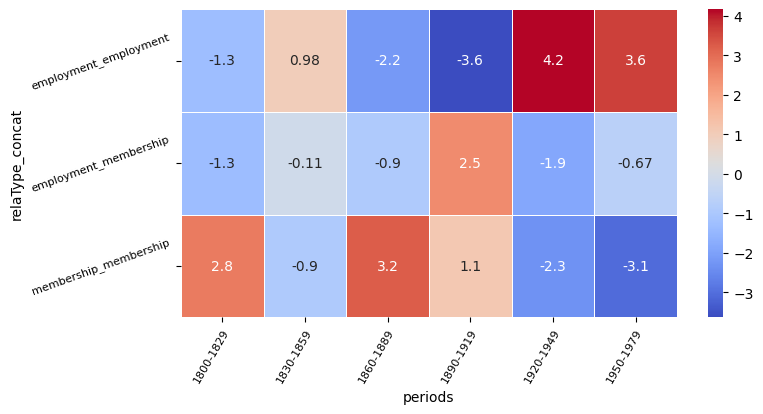

In [76]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 4))

## Graph analysis


We will explore some aspects of the relationships:

* which organisations are connected through education, but this only at the level of universities, not earlier education stages
* in the same perspective (same kind of relations), we will explore memberships and employments, keeping them separated
* we will then ask what appears regarding the relationship between employment and membership
* we finally inspect if some kind of educational institutions (at unversity level) lead to specific employments or memberships.






### Organisations connected through higher education

In [77]:
pprint.pprint(sorted(df_mainTypes.mainType.to_list()))

['generic organisation',
 'international organisation',
 'learned society',
 'musical group',
 'non-governmental organisation',
 'political organisation',
 'university']


In [78]:
types_list=['generic organisation',
 'international organisation',
 'learned society',
 'musical group',
 'non-governmental organisation',
 'political organisation',
 'university']

In [79]:
df_member_graph = df_graph[(df_graph.relaType_concat == 'membership_membership') \
                     & (df_graph.orgMainType_x.isin(types_list)) \
                     & (df_graph.orgMainType_y.isin(types_list))  ]

print(len(df_member_graph))
df_member_graph.iloc[:2]

246


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
0,1800-1829,membership_membership,http://www.wikidata.org/entity/Q17056522,United Kingdom Alliance,generic organisation,http://www.wikidata.org/entity/Q2154954,Vegetarian Society,generic organisation,James Simpson,http://www.wikidata.org/entity/Q124408682,1
1,1800-1829,membership_membership,http://www.wikidata.org/entity/Q17056522,United Kingdom Alliance,generic organisation,http://www.wikidata.org/entity/Q4903078,Bible Christian Church,generic organisation,James Simpson,http://www.wikidata.org/entity/Q124408682,1


In [80]:
df_member_graph.sort_values(by='number',ascending=False).iloc[:2]

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
132,1860-1889,membership_membership,http://www.wikidata.org/entity/Q60564688,International Committee of Women for Permanent...,international organisation,http://www.wikidata.org/entity/Q689768,Women's International League for Peace and Fre...,international organisation,Jane Addams|Kathleen Courtney|Vilma Glücklich|...,http://www.wikidata.org/entity/Q180989|http://...,5
455,1890-1919,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,learned society,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,learned society,Albert Szent-Györgyi|Linus Pauling,http://www.wikidata.org/entity/Q180468|http://...,2


In [81]:
### Number of relationships by period
print(df_member_graph.groupby('periods').size())

periods
1800-1829      5
1830-1859      2
1860-1889     58
1890-1919    123
1920-1949     52
1950-1979      6
dtype: int64


### Inspect a specific period

In [82]:
p = '1890-1919' 

In [83]:
df_member_graph_p = df_member_graph[(df_member_graph.periods==p)]
df_member_graph_p.sort_values(by='number',ascending=False).head(2)

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
455,1890-1919,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,learned society,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,learned society,Albert Szent-Györgyi|Linus Pauling,http://www.wikidata.org/entity/Q180468|http://...,2
474,1890-1919,membership_membership,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,learned society,Albert Szent-Györgyi|Linus Pauling,http://www.wikidata.org/entity/Q180468|http://...,2


In [84]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriOrg_x'], e['uriOrg_y'],
     {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
      ## the weight ist the number of persons in this relationship
      'weight':e['number']}
     )) 
     for e in df_member_graph_p.to_dict(orient='records')]
print(len(l))

123


In [85]:
member_graph_p=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
member_graph_p.add_edges_from(l)

naf.basic_graph_properties(member_graph_p)

### Create a list of graphs, one per component
member_graph_p_S = [member_graph_p.subgraph(c).copy() for c in nx.connected_components(member_graph_p)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(member_graph_p_S)], key = lambda row: row[1], reverse=True)
print(ln[:5])

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 43,
 'number_of_edges': 123,
 '------': '------',
 'is connected': False,
 'components': 7,
 'density': 0.1362126245847176}
[[2, 17], [1, 13], [0, 3], [3, 3], [5, 3]]


In [86]:
### test if second component is significantly smaller 
# than first
if ln[1][1]*20 < ln[0][1]:
    print('Just one big component')
else :
    print('Beware: more than one big component !')    

Beware: more than one big component !


In [90]:
### Alternative way with just one graph
pG = member_graph_p_S[0]
naf.basic_graph_properties(pG)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 3,
 'number_of_edges': 3,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 1.0}


In [91]:
df_orgPeriod.sort_values(by='period_members_number', ascending=False).head(2)

,uriOrg,labelOrg,orgMainType,periods,period_members_number
428,http://www.wikidata.org/entity/Q60564688,International Committee of Women for Permanent...,international organisation,1860-1889,17
457,http://www.wikidata.org/entity/Q689768,Women's International League for Peace and Fre...,international organisation,1860-1889,16


In [92]:
df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']
df_opl.head()


,uri,label,mainType,membersNumber
8,http://www.wikidata.org/entity/Q1046722,Industrial Workers of the World,international organisation,2
11,http://www.wikidata.org/entity/Q1047293,"University of California, Santa Cruz",university,1
17,http://www.wikidata.org/entity/Q105317493,Q105317493,generic organisation,1
26,http://www.wikidata.org/entity/Q1075116,Colby College,university,1
29,http://www.wikidata.org/entity/Q107921129,World Committee of Women Against War and Fascism,international organisation,3


In [93]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'mainType':e['mainType'],
                        'membersNumber':e['membersNumber']}
     ) for e in df_opl.to_dict(orient='records')])
## Add attributes
nx.set_node_attributes(pG, ln)
pprint.pprint(list(pG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q2157083',
  {'label': 'Silent Sentinels',
   'mainType': 'generic organisation',
   'membersNumber': 1}),
 ('http://www.wikidata.org/entity/Q623009',
  {'label': "National Woman's Party",
   'mainType': 'generic organisation',
   'membersNumber': 1})]


In [94]:
mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
print(mn_s.groupby(by=mn_s).size().sort_values(ascending=False))

generic organisation          2
international organisation    1
dtype: int64


####  Create dataframe and inspect node properties

In [95]:
### Eigenvector
le = list(nx.eigenvector_centrality(pG, 
                        max_iter=200, weight='weight').items())
nx.set_node_attributes(pG, dict(le), 'eigenvector')
pprint.pprint(list(pG.nodes.data())[:1])

[('http://www.wikidata.org/entity/Q2157083',
  {'eigenvector': 0.5773502691896258,
   'label': 'Silent Sentinels',
   'mainType': 'generic organisation',
   'membersNumber': 1})]


In [96]:
### Betweenness
lb = list(nx.betweenness_centrality(pG, weight='weight').items())
nx.set_node_attributes(pG, dict(lb), 'betweenness')
pprint.pprint(list(pG.nodes.data())[:1])


[('http://www.wikidata.org/entity/Q2157083',
  {'betweenness': 0.0,
   'eigenvector': 0.5773502691896258,
   'label': 'Silent Sentinels',
   'mainType': 'generic organisation',
   'membersNumber': 1})]


In [97]:
### Export node attributes to dataframe
nodes_data ={node: pG.nodes[node] for node in pG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True, names='id')
nodes_df.head(2)


,id,label,mainType,membersNumber,eigenvector,betweenness
0,http://www.wikidata.org/entity/Q2157083,Silent Sentinels,generic organisation,1,0.57735,0.0
1,http://www.wikidata.org/entity/Q623009,National Woman's Party,generic organisation,1,0.57735,0.0


In [98]:
df_mainTypes

,mainType,number
0,generic organisation,275
6,university,229
1,international organisation,72
4,non-governmental organisation,40
2,learned society,36
5,political organisation,14
3,musical group,13


In [99]:
df_graph[['labelOrg_x', 'labelOrg_y', 'orgMainType_x', 'orgMainType_y']]


,labelOrg_x,labelOrg_y,orgMainType_x,orgMainType_y
0,United Kingdom Alliance,Vegetarian Society,generic organisation,generic organisation
1,United Kingdom Alliance,Bible Christian Church,generic organisation,generic organisation
2,Q21406862,Association of German Engineers,generic organisation,generic organisation
3,Vegetarian Society,Bible Christian Church,generic organisation,generic organisation
4,American Anti-Imperialist League,American Academy of Arts and Sciences,political organisation,learned society
...,...,...,...,...
783,Indymedia,Food Not Bombs,generic organisation,generic organisation
784,Stop the War Coalition,General Council of the Trades Union Congress,non-governmental organisation,generic organisation
785,National Tertiary Education Union,Jews Against the Occupation,generic organisation,generic organisation
786,Clamshell Alliance,Food Not Bombs,political organisation,generic organisation


In [101]:
import networkx as nx

# Créer un graphe orienté ou non (selon ton besoin)
G = nx.Graph()

# Ajouter les arêtes (relations)
for _, row in df_graph.iterrows():
    src = row['labelOrg_x']
    tgt = row['labelOrg_y']
    w = row.get('number', 1)  # utilise 'number' si présent, sinon 1
    G.add_edge(src, tgt, weight=w, 
               type_source=row['orgMainType_x'], 
               type_target=row['orgMainType_y'])


In [102]:
print(f"Nombre de noeuds : {G.number_of_nodes()}")
print(f"Nombre d'arêtes : {G.number_of_edges()}")
print(f"Degré moyen : {sum(dict(G.degree()).values())/G.number_of_nodes():.2f}")

# Centralité
centrality = nx.betweenness_centrality(G)
nx.set_node_attributes(G, centrality, "betweenness")

# Eigenvector centrality (optionnel, si graphe connexe)
try:
    eigen = nx.eigenvector_centrality(G)
    nx.set_node_attributes(G, eigen, "eigenvector")
except:
    print("Graphe non connexe pour eigenvector centrality")


Nombre de noeuds : 358
Nombre d'arêtes : 780
Degré moyen : 4.36


In [103]:
colors = []
for node in G.nodes():
    type_ = None
    for edge in G.edges(node, data=True):
        if edge[0] == node:
            type_ = edge[2].get('type_source')
        elif edge[1] == node:
            type_ = edge[2].get('type_target')
        if type_: break
    colors.append(color_map.get(type_, '#999999'))


NameError: name 'color_map' is not defined

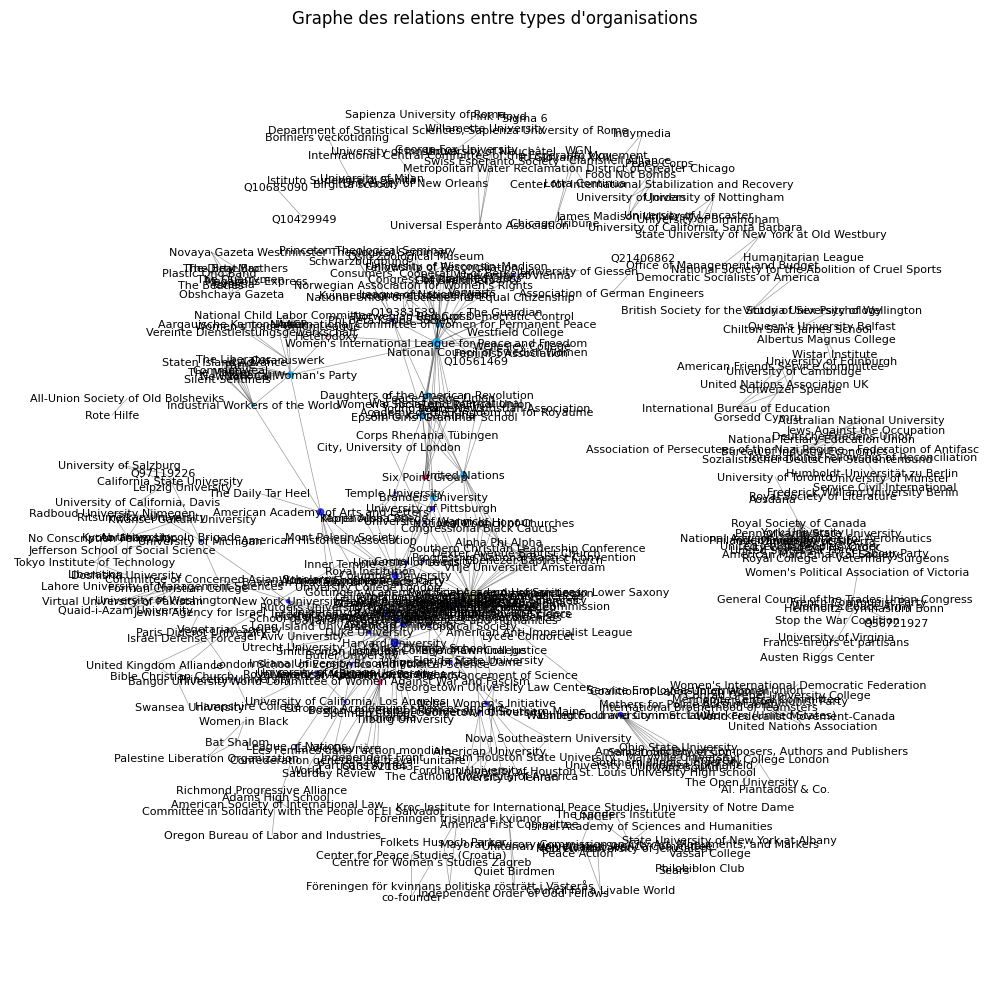

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.15, iterations=50)

# Taille en fonction du betweenness
sizes = [500 * G.nodes[n].get('betweenness', 0.01) for n in G.nodes]

nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, alpha=0.7)
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Graphe des relations entre types d'organisations")
plt.axis('off')
plt.tight_layout()
plt.show()


In [104]:
import networkx as nx
import plotly.graph_objects as go

# Exemple de graph (à adapter à ton G)
pos = nx.spring_layout(G, seed=42)
edge_x, edge_y = [], []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x, node_y = [], []
node_color, node_text = [], []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_color.append(color_map.get(G.nodes[node].get('type', ''), '#999'))
    node_text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    marker=dict(
        color=node_color,
        size=10,
        line=dict(width=1)
    ),
    hoverinfo='text')

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Réseau interactif Plotly',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40)
                ))
fig.show()


NameError: name 'color_map' is not defined

In [101]:
### source
# https://phrogz.net/css/distinct-colors.html
col_l = [c.strip() for c in '#ff0066, #0000ff, #00aaff,#beb6f2, #b6e6f2, #e6f2b6, #f2b6b6,#2d50b3, #ccff00, #8c005e, #8c8300'.split(',')]
print(col_l)

['#ff0066', '#0000ff', '#00aaff', '#beb6f2', '#b6e6f2', '#e6f2b6', '#f2b6b6', '#2d50b3', '#ccff00', '#8c005e', '#8c8300']


In [102]:
col_list= [e for e in zip(lt, col_l)]
print(col_list)

[('generic organisation', '#ff0066'), ('university', '#0000ff'), ('international organisation', '#00aaff'), ('non-governmental organisation', '#beb6f2'), ('learned society', '#b6e6f2'), ('political organisation', '#e6f2b6'), ('musical group', '#f2b6b6')]


In [103]:
color_map=dict([(c[0], (c[1])) for c in col_list])
pprint.pprint(color_map)

{'generic organisation': '#ff0066',
 'international organisation': '#00aaff',
 'learned society': '#b6e6f2',
 'musical group': '#f2b6b6',
 'non-governmental organisation': '#beb6f2',
 'political organisation': '#e6f2b6',
 'university': '#0000ff'}


In [104]:
### Manually modified list
color_map = {'generic organisation': '#ff0066',
 'international organisation': '#00aaff',
 'learned society': '#b6e6f2',
 'musical group': '#f2b6b6',
 'non-governmental organisation': '#beb6f2',
 'political organisation': '#e6f2b6',
 'university': '#0000ff'}

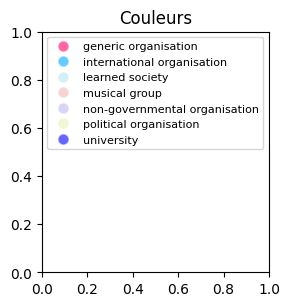

In [105]:

fig = plt.figure(figsize=(3,3))


### Create lists of colors and labels
colors = [color_map.keys()]
 

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=0.6
                            ) for label, color in color_map.items() ],
                            loc='upper left', fontsize=8)
plt.tight_layout() # rect=[0,0,0.8,1]

plt.title('Couleurs')

plt.show()

In [ ]:
### Create a function that plots the comparison between values and properties

def compare_with_scatter_plot(dataframe, value_1, value_2, point_column,point_ratio=1, 
                              c_category='', color_map='', figsize=(12,12), 
                              legend_loc='upper right',title='', 
                              n_label ='', label_cut_value=''):

    ### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    # Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
    # Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    # Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point



    df=dataframe
    #df_extr=nodes_df[nodes_df.betweenness > 0].sort_values(by='betweenness', ascending=False)

    alpha=0.7

    ### Manage point colors:
    # https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/

    plt.figure(figsize=figsize)


    ### Create lists of colors and labels
    colors = [color_map[category] for category in df[c_category]]
 



    ax = plt.scatter(df[value_1],
                df[value_2],
            marker='o',
            s = [v*point_ratio for i,v in df[point_column].items()],
            color=colors,        
            alpha=alpha)
    plt.xlabel(value_1.capitalize())
    plt.ylabel(value_2.capitalize())






    ### Labels
    test_v1 = df[value_1].quantile([0.97]).item()
    test_v2 = df[value_2].quantile([0.95]).item()
    print(test_v1,test_v2)


    if len(n_label)>0:
        for i,row in list(df.loc[(df[value_1]>test_v1)|(df[value_2]>test_v2)]\
                          [[n_label,value_1,value_2]].iterrows()):
            plt.annotate(row[n_label][:30],(row[value_1], row[value_2]), fontsize=6)

    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=alpha
                            ) for label, color in color_map.items() 
                                    if label in types_list ],
                            loc=legend_loc, fontsize=8)
    plt.tight_layout() # rect=[0,0,0.8,1]

    plt.title(title)

    # plt.savefig('plots/revenus_eigenvector_20210526.jpg')
    plt.show()

0.5773502691896258 0.0


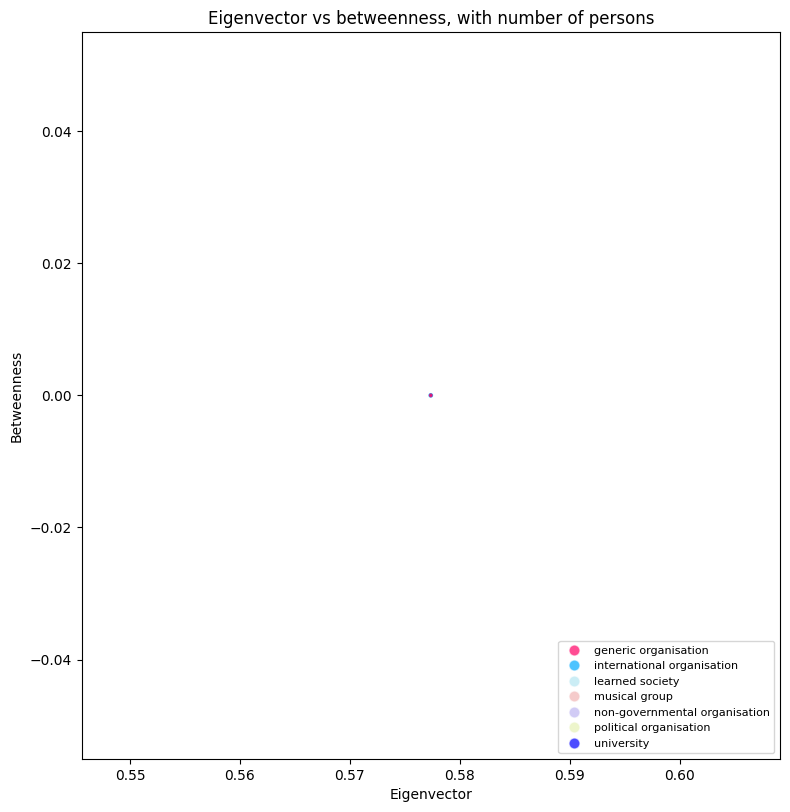

Spearman's rank correlation: nan


In [107]:
compare_with_scatter_plot(nodes_df, 'eigenvector', 'betweenness', 'membersNumber', 
                          point_ratio=3, c_category='mainType',
                          color_map=color_map, figsize=(8,8), 
                          legend_loc='lower right', 
                          title='Eigenvector vs betweenness, with number of persons', 
                          n_label='label', label_cut_value='membersNumber' )

corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
print("Spearman's rank correlation: {}".format(corr_spear.iloc[0,1]))

In [ ]:
import matplotlib.pyplot as plt

def compare_with_scatter_plot(dataframe, value_1, value_2, point_column,
                              point_ratio=1, c_category='', color_map=None,
                              figsize=(12,12), legend_loc='upper right',
                              title='', n_label='', label_cut_value=''):

    df = dataframe.copy()
    alpha = 0.7

    # Gestion de la couleur des points selon la catégorie
    if color_map and c_category in df.columns:
        try:
            colors = [color_map.get(cat, 'gray') for cat in df[c_category]]
        except Exception as e:
            print("Erreur lors de la génération des couleurs :", e)
            colors = 'gray'
    else:
        colors = 'gray'  # fallback si aucun color_map fourni

    # Création de la figure
    plt.figure(figsize=figsize)

    # Tracé du scatter plot
    scatter = plt.scatter(
        df[value_1],
        df[value_2],
        marker='o',
        s=[v * point_ratio for v in df[point_column]],
        c=colors,
        alpha=alpha
    )

    plt.xlabel(value_1.capitalize())
    plt.ylabel(value_2.capitalize())

    # Détermination des seuils pour affichage des labels
    try:
        test_v1 = df[value_1].quantile(0.97)
        test_v2 = df[value_2].quantile(0.95)
    except:
        test_v1 = df[value_1].max()
        test_v2 = df[value_2].max()

    # Affichage des labels si demandé
    if n_label and n_label in df.columns:
        for _, row in df.loc[(df[value_1] > test_v1) | (df[value_2] > test_v2)].iterrows():
            plt.annotate(str(row[n_label])[:30], (row[value_1], row[value_2]), fontsize=6)

    # Création de la légende
    if color_map and c_category in df.columns:
        unique_types = df[c_category].unique()
        handles = [
            plt.Line2D([0], [0], marker='o', color='w',
                       label=label, markerfacecolor=color_map[label],
                       markersize=8, alpha=alpha)
            for label in unique_types if label in color_map
        ]
        plt.legend(handles=handles, loc=legend_loc, fontsize=8)

    plt.title(title)
    plt.tight_layout()
    plt.show()


In [108]:
list(nodes_df.columns)

['id', 'label', 'mainType', 'membersNumber', 'eigenvector', 'betweenness']

In [109]:
print('Betweenness')
pprint.pprint((nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))
print('\n-----\nEigenvector')
pprint.pprint((nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))

Betweenness
                             label                    mainType membersNumber
0                 Silent Sentinels        generic organisation             1
1  Industrial Workers of the World  international organisation             2
2           National Woman's Party        generic organisation             1

-----
Eigenvector
                             label                    mainType membersNumber
0                 Silent Sentinels        generic organisation             1
1  Industrial Workers of the World  international organisation             2
2           National Woman's Party        generic organisation             1


#### Plot graph

In [ ]:
pict_addr = 'images/organisations/member_member_' + p +'.svg'
print(pict_addr)

images/organisations/edu_edu_1890-1919.svg


C:\Users\rroll\AppData\Local\Temp\ipykernel_26892\452596361.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=60)


FileNotFoundError: [Errno 2] No such file or directory: 'images/organisations/edu_edu_1890-1919.svg'

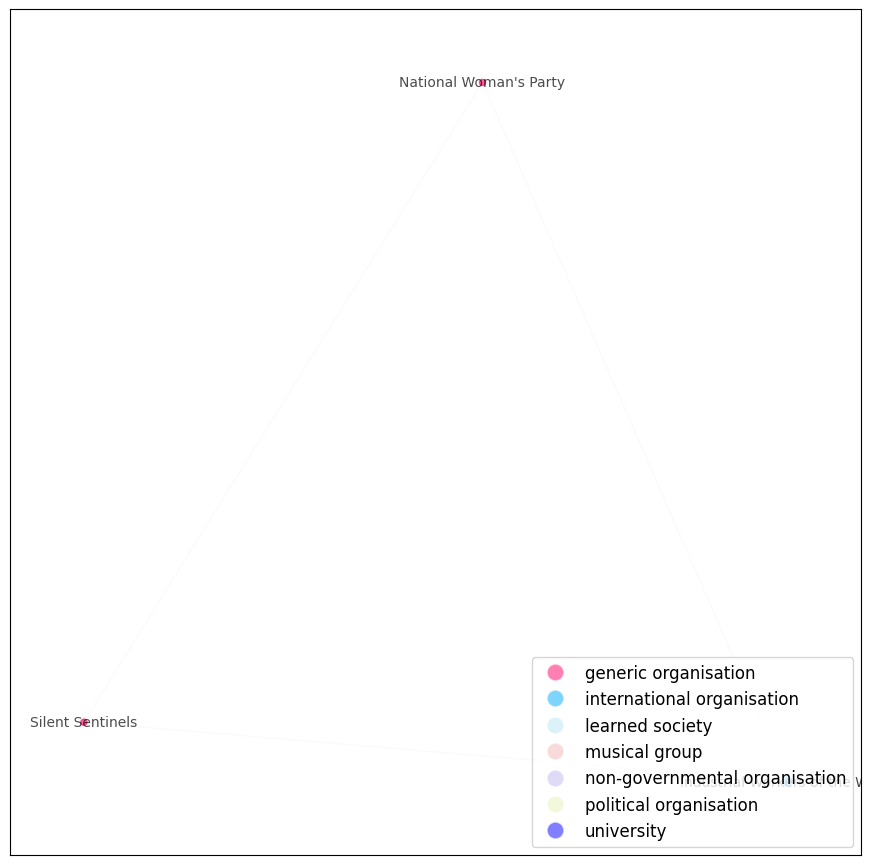

In [111]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]
node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                        label=label, markerfacecolor=color, 
                        markersize=12, alpha=alpha_n
                        )
                        for label, color in color_map.items()
                        if label in types_list ],
                        loc='lower right', fontsize=12)


### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr
plt.savefig(pict_addr)
#plt.show()
plt.close()


### Communitites

In [112]:
l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
print( len(l_communities))
sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
print([c[1] for c in sl_communities])
print(sl_communities[-1:])


1
[3]
[({'http://www.wikidata.org/entity/Q2157083', 'http://www.wikidata.org/entity/Q623009', 'http://www.wikidata.org/entity/Q1046722'}, 3)]


In [113]:
for i in range(0,5):
   print('\n\nCommunity '+ str(i), '\nBetweenness')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))
   print('\n-----\nEigenvector')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))




Community 0 
Betweenness
                             label                    mainType membersNumber
0                 Silent Sentinels        generic organisation             1
1  Industrial Workers of the World  international organisation             2
2           National Woman's Party        generic organisation             1

-----
Eigenvector
                             label                    mainType membersNumber
0                 Silent Sentinels        generic organisation             1
1  Industrial Workers of the World  international organisation             2
2           National Woman's Party        generic organisation             1


Community 1 
Betweenness


IndexError: list index out of range

#### Plot communitites graph

In [114]:
pict_addr_comm = 'images/organisations/edu_edu_communities_' + p +'.svg'
print(pict_addr_comm)

images/organisations/edu_edu_communities_1890-1919.svg


C:\Users\rroll\AppData\Local\Temp\ipykernel_26892\2935194816.py:60: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=60)


FileNotFoundError: [Errno 2] No such file or directory: 'images/organisations/edu_edu_communities_1890-1919.svg'

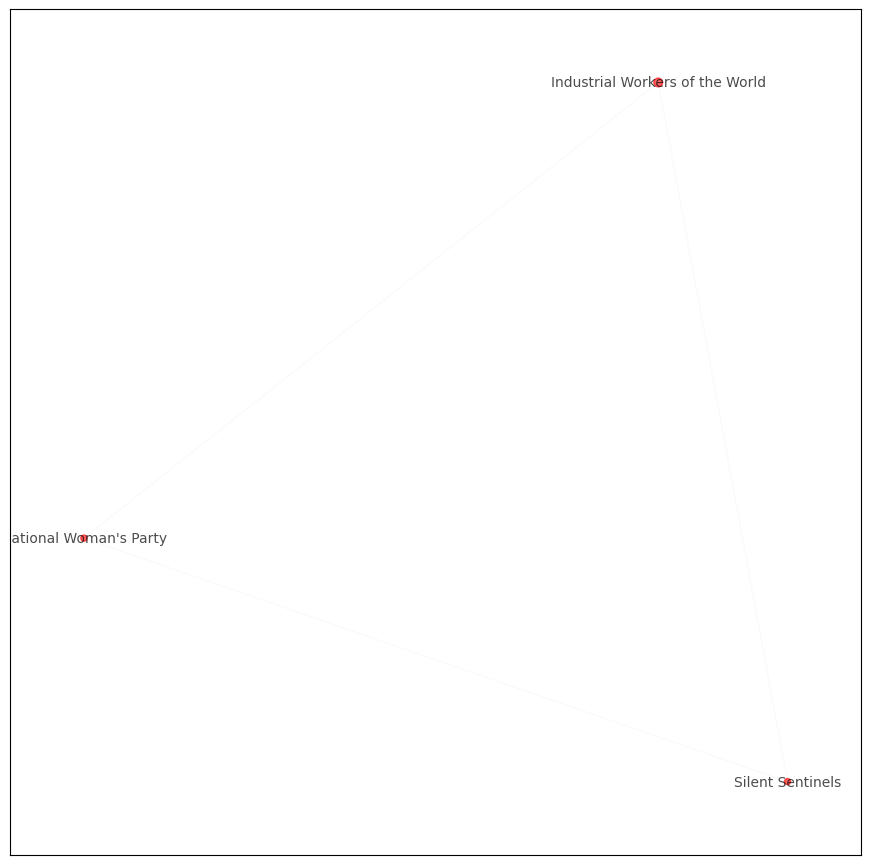

In [115]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]

node_colors = []
for n in g.nodes.data():
    if n[0] in list(sl_communities[0][0]):
        node_colors.append('red')
    elif n[0] in list(sl_communities[1][0]):
        node_colors.append('blue')
    elif n[0] in list(sl_communities[2][0]):
        node_colors.append('green')
    elif n[0] in list(sl_communities[3][0]):
        node_colors.append('orange')
    elif n[0] in list(sl_communities[4][0]):
        node_colors.append('maroon')
    else:
        node_colors.append('lightGrey')        


edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5



### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr_comm
plt.savefig(pict_addr)
#plt.show()
plt.close()


## Create general function

In [ ]:
def generate_report_and_plots(df, concatRelaType, type_list, doc_addr, df_orgPeriod):

    with open(doc_addr, "w") as myfile:
        myfile.write('# Report for relations: ' + concatRelaType + '\n')


    df_g = df[(df.relaType_concat == concatRelaType) \
                     & (df.orgMainType_x.isin(type_list)) \
                     & (df.orgMainType_y.isin(type_list))  ]

    txt = str(df_g.groupby('periods').size())

    with open(doc_addr, "a") as myfile:
        myfile.write('\n'+txt + '\n')

    for p in df_g['periods'].unique():
        print(str(p))   

        with open(doc_addr, "a") as myfile:
            myfile.write('\n\n\n## Values for ' + p + '\n')

        df_g_p = df_g[df_g.periods==p]
        
        with open(doc_addr, "a") as myfile:
            myfile.write('\nNumber of relationships for this period ' + str(len(df_g_p)) + '\n')
        
        l = [tuple(
            (e['uriOrg_x'], e['uriOrg_y'],
            {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
            ## the weight ist the number of persons in this relationship
            'weight':e['number']}
            )) 
            for e in df_g_p.to_dict(orient='records')]
        
        graph_p=nx.Graph()
        graph_p.add_edges_from(l)

        txt = 'Number of nodes: ' + str(graph_p.number_of_nodes())+\
                '\nNumber of edges: ' + str(graph_p.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### Components
        graph_p_S = [graph_p.subgraph(c).copy() 
                     for c in nx.connected_components(graph_p)]

        ln = sorted([[i,len(s.nodes)] for i,s in enumerate(graph_p_S)], key = lambda row: row[1], reverse=True)
        try:
            if ln[1][1]*20 < ln[0][1]:
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nJust one big component with ' + str(graph_p_S[0].number_of_nodes()) + ' nodes\n')            
            else :
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nBeware: more than one big component !'  + '\n')
        except Exception as e:
             print(e)            
            
        ### Alternative way with just one graph
        pG = graph_p_S[0]

        txt = 'Number of nodes for first component: ' + str(pG.number_of_nodes())+\
                '\nNumber of edges for first component: ' + str(pG.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### No treatment for smaller graphs
        if int(pG.number_of_nodes()) > 30:

            ### Prepare data to add to nodes

            df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
            df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']

            ln = dict([(e['uri'],
                {'label':e['label'], 'mainType':e['mainType'],
                                    'membersNumber':e['membersNumber']}
                ) for e in df_opl.to_dict(orient='records')])
            ## Add attributes
            nx.set_node_attributes(pG, ln)

            mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
            txt= str(list(mn_s.groupby(by=mn_s).size().sort_values(ascending=False).items()))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            ### Eigenvector
            try:
                le = list(nx.eigenvector_centrality(pG, 
                                        max_iter=1000, weight='weight').items())
            except Exception as e:
                print(e)    
            nx.set_node_attributes(pG, dict(le), 'eigenvector')   

            ### Betweenness
            lb = list(nx.betweenness_centrality(pG, weight='weight').items())
            nx.set_node_attributes(pG, dict(lb), 'betweenness')


            ### Export node attributes to dataframe
            nodes_data ={node: pG.nodes[node] for node in pG.nodes}
            nodes_df = pd.DataFrame(nodes_data).T
            nodes_df.reset_index(inplace=True, names='id')

            corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
            txt = "Spearman's rank correlation of eidenvector and betweenness: {}".format(corr_spear.iloc[0,1])
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            txt = 'Eigenvector\n' + \
                str(nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7) )+\
                '\n-----\nBetweenness'+\
                str(nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')


            pict_addr = 'images/organisations/' + concatRelaType + '_' + p +'.svg'        


            ### Plot the graph
            g = pG
            # n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
            n_size = np.log(nx.number_of_nodes(g))*10

            graph_layout = 'spring_layout'
            n_k = np.log(nx.number_of_nodes(g))/20 #2.5

            ### Define the layout, i.e. the choice 
            # of the algorithm for the representation of the graph.

            if graph_layout == 'fruchterman_reingold':
                pos = nx.fruchterman_reingold_layout(g)
            elif graph_layout == 'kamada_kawai':
                pos = nx.kamada_kawai_layout(g)
            elif graph_layout == 'spring_layout':
                pos = nx.spring_layout(g, k = n_k)  
            else:
                pos = nx.kamada_kawai_layout(g)

            # https://networkx.org/documentation/stable/reference/drawing.html
            plt.figure(figsize = (n_size,n_size))

            node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
            #node_size = [d[1]*100 for d in nx.degree(g)]
            #node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

            edge_size = [e[2]['weight'] for e in g.edges.data()]
            edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

            node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


            nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color='blue', alpha=0.6)
            nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
            nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
            #nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

            alpha_n=0.5

            plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                                    label=label, markerfacecolor=color, 
                                    markersize=8, alpha=alpha_n
                                    )
                                    for label, color in color_map.items()],
                                    loc='lower right', fontsize=8)


            ### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
            plt.tight_layout(pad=60)
            pict_addr = pict_addr
            plt.savefig(pict_addr)
            #plt.show()
            plt.close()


            ### Identify communitites
            l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
            sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
            txt= 'Number of communitites: ' + str(len(l_communities)) +\
                    '\nNumber of nodes per community: ' + str([c[1] for c in sl_communities])
            with open(doc_addr, "a") as myfile:
                myfile.write('\n'+ txt  + '\n')

            communities_print = 'Communities: \n'
            try:
                for i in range(0,5):
                    communities_print += '\n\nCommunity '+ str(i) + '\nBetweenness'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ]\
                                                .sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                    communities_print += '\n-----\nEigenvector'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ communities_print  + '\n')
            except Exception as e:
                 print(e)        

        else:
            print('Too small graph to be analyzed!')        


In [ ]:
print(df_mainTypes.mainType.to_list())

In [ ]:
relationship_type = 'education_education'
generate_report_and_plots(df_graph, relationship_type,
                           ['university','public university','private university'],
                           'analysis_doc/'+relationship_type+'.md',
                           df_orgPeriod)

In [ ]:
relationship_type = 'membership_membership'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

In [ ]:
relationship_type = 'employment_employment'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)